In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

### Dominick sales data from https://www.chicagobooth.edu/research/kilts/research-data/dominicks

In [5]:
df = pd.read_csv(r"C:\causal inference and causal ML\Dominicks\cola_clean.csv")

In [7]:
df.shape

(1400, 14)

In [9]:
df.head()

,STORE,UPC,WEEK,brand,product_type_regular,MOVE,log_price_1200000017,log_price_1200000053,log_price_4900001063,log_price_4900001278,promo,PROFIT,log_move,DATE
0,2,1200000017,50,PEPSI,True,1.0,2.078191,0.000000,0.000000,0.000000,0.0,26.16,0.693147,1990-08-23
1,2,1200000017,51,PEPSI,True,680.0,1.585145,1.585145,0.000000,2.078191,1.0,20.90,6.523562,1990-08-30
2,2,1200000017,52,PEPSI,True,10.0,2.078191,0.000000,2.078191,2.078191,0.0,26.16,2.397895,1990-09-06
3,2,1200000017,53,PEPSI,True,1.0,2.078191,2.078191,0.000000,2.078191,0.0,26.16,0.693147,1990-09-13
4,2,1200000017,54,PEPSI,True,12.0,2.078191,0.000000,0.000000,0.000000,1.0,26.16,2.564949,1990-09-20


In [11]:
df.describe()
# move is sales

,STORE,UPC,WEEK,MOVE,log_price_1200000017,log_price_1200000053,log_price_4900001063,log_price_4900001278,promo,PROFIT,log_move
count,1400.0,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.0,3.050001e+09,224.500000,18.982143,1.719788,1.603852,1.597487,1.633252,0.334286,-2.440579,1.935547
std,0.0,1.850662e+09,101.071988,42.347861,0.645670,0.752693,0.745809,0.737471,0.471909,24.536682,1.440467
min,2.0,1.200000e+09,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-98.830000,0.000000
25%,2.0,1.200000e+09,137.000000,1.000000,1.790091,1.638997,1.607436,1.646734,0.000000,-15.520000,0.693147
50%,2.0,3.050001e+09,224.500000,5.000000,1.944481,1.944481,1.944481,1.944481,0.000000,0.000000,1.791759
75%,2.0,4.900001e+09,312.000000,22.250000,2.026832,2.026832,2.026832,2.026832,1.000000,8.820000,3.146134
max,2.0,4.900001e+09,399.000000,713.000000,2.150599,2.150599,2.150599,2.150599,1.000000,86.610000,6.570883


In [13]:
df['brand'].value_counts()

brand
PEPSI        672
Coca Cola    672
Name: count, dtype: int64

### there are cases where price=0 and sales =0, drop them in training dataset later

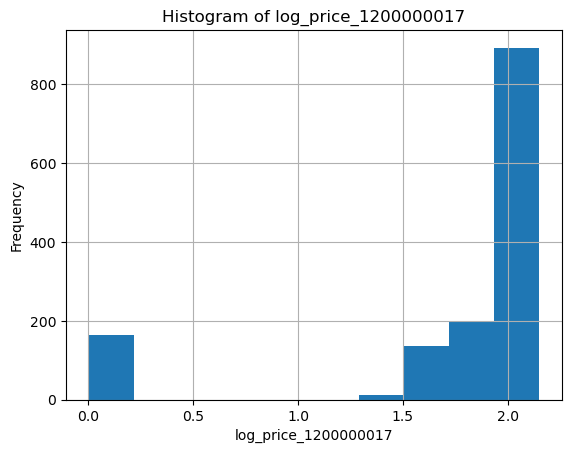

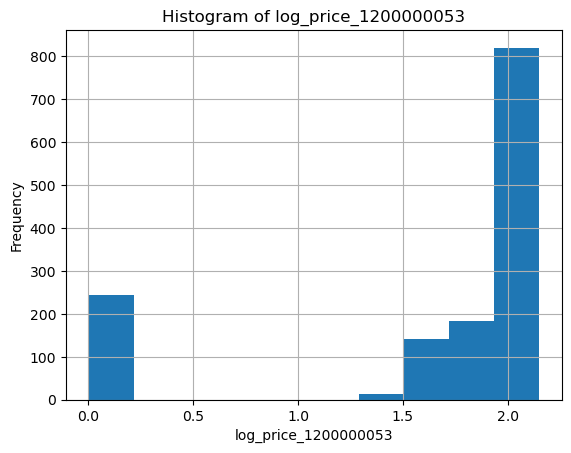

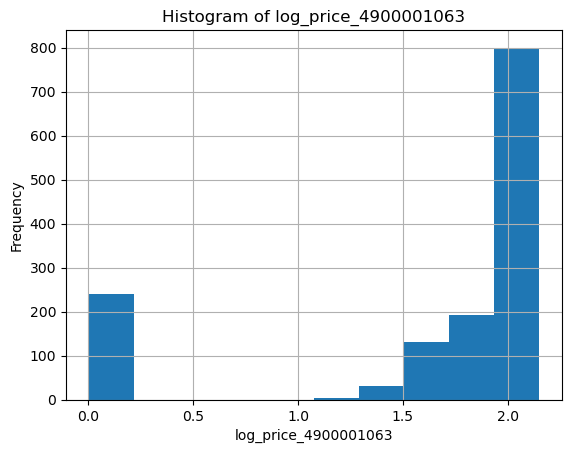

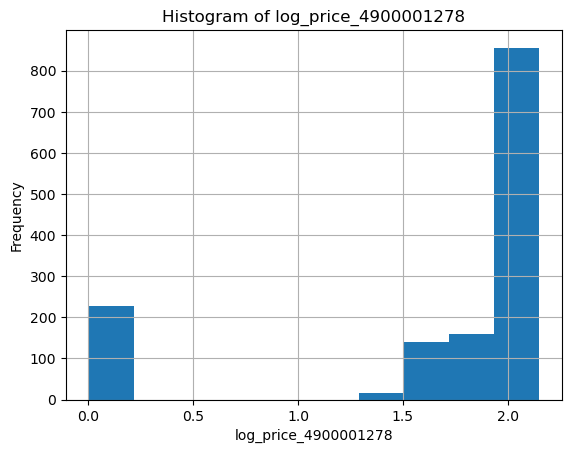

In [15]:
for v in ['log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063', 'log_price_4900001278']:
    df[v].hist()
    plt.title(f'Histogram of {v}')
    plt.xlabel(v)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [17]:
for v in ['log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063', 'log_price_4900001278']:
    print(df[(df['UPC']==int(v.split('_')[-1]))&(df[v]==0)]['MOVE'].describe())

count    41.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: MOVE, dtype: float64
count    61.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: MOVE, dtype: float64
count    60.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: MOVE, dtype: float64
count    57.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: MOVE, dtype: float64


### sales outliers: associated with promo

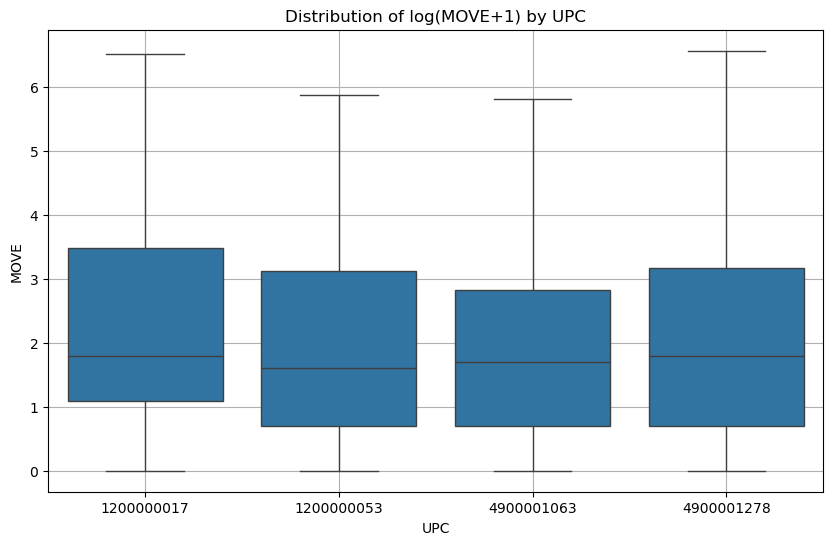

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='UPC', y='log_move')
plt.title('Distribution of log(MOVE+1) by UPC')
plt.xlabel('UPC')
plt.ylabel('MOVE')
plt.grid(True)
plt.show()

In [22]:
df[(df.UPC==4900001278)&(df.log_move>6)][['promo']]

,promo
1115,1.0


### features used for forecasting

In [24]:
df.columns

Index(['STORE', 'UPC', 'WEEK', 'brand', 'product_type_regular', 'MOVE',
       'log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063',
       'log_price_4900001278', 'promo', 'PROFIT', 'log_move', 'DATE'],
      dtype='object')

In [26]:
df.isnull().sum()

STORE                    0
UPC                      0
WEEK                     0
brand                   56
product_type_regular    56
MOVE                     0
log_price_1200000017     0
log_price_1200000053     0
log_price_4900001063     0
log_price_4900001278     0
promo                    0
PROFIT                   0
log_move                 0
DATE                     0
dtype: int64

In [28]:
df.loc[df.UPC==1200000017,'brand'] = 'Coca Cola'
df.loc[df.UPC==1200000053,'brand'] = 'Coca Cola'
df.loc[df.UPC==4900001063,'brand'] = 'PEPSI'
df.loc[df.UPC==4900001278,'brand'] = 'PEPSI'
df.loc[df.UPC==1200000017,'product_type_regular'] = 1
df.loc[df.UPC==1200000053,'product_type_regular'] = 0 # diet
df.loc[df.UPC==4900001063,'product_type_regular'] = 1
df.loc[df.UPC==4900001278,'product_type_regular'] = 0 # diet

In [30]:
# lagged sales
for lag in [1, 2, 3, 4, 5, 6, 52]:
    df[f'lag_{lag}'] = df.groupby(['UPC', 'STORE'])['log_move'].shift(lag)
# moving average sales
for window in [3, 4, 12, 52]:
    df[f'rolling_mean_{window}'] = (
        df.groupby(['UPC', 'STORE'])['log_move']
        .shift(1) 
        .rolling(window=window)
        .mean()
    )

In [32]:
df['week_start'] = df['WEEK'].apply(lambda x: pd.to_datetime(df['DATE'][0]) + pd.Timedelta(days=(x - 1) * 7))
df['weekofyear'] = df['week_start'].dt.isocalendar().week
df['month'] = df['week_start'].dt.month
df['quarter'] = df['week_start'].dt.quarter
df['year'] = df['week_start'].dt.year
df['dayofweek'] = df['week_start'].dt.dayofweek  
df['weekend'] = df['dayofweek'] >= 5             
df['day'] = df['week_start'].dt.day

### category

In [34]:
df['STORE'] = df['STORE'].astype('category')
df['brand'] = df['brand'].astype('category')

### last quarter (13 weeks) as test set, assume price and promo in the last quarter are planned in advance and so known when forecasting

In [38]:
df_list = []

for upc, group in df.groupby('UPC'):
    group = group.sort_values('WEEK')
    group.loc[group.index[:-13], 'set'] = 'train'
    group.loc[group.index[-13:], 'set'] = 'test'
    df_list.append(group)

df = pd.concat(df_list).sort_values(['UPC', 'WEEK'])

In [40]:
df['product_type_regular'] = df['product_type_regular'].astype(int)

In [42]:
train = df[df['set'] == 'train']
test = df[df['set'] == 'test']

### Drop rows with zero sales and zero price in training data, and drop those missing in training data due to lagged and moving average 

In [47]:
print(train.shape)
for v in ['log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063', 'log_price_4900001278']:
    upc = int(v.split('_')[-1])
    train = train[~((train['UPC'] == upc) & (train[v] == 0))]
print(train.shape)

(1348, 34)
(1133, 34)


In [49]:
# lagged log_sales and moving average missing
print(train.shape)
train = train.dropna()
print(train.shape)

(1133, 34)
(1030, 34)


In [36]:
X = ['STORE', 'brand', 'product_type_regular', 
                'log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063',
                'log_price_4900001278', 'promo', 'PROFIT', 
                'lag_1','lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_52', 
                'rolling_mean_3','rolling_mean_4', 'rolling_mean_12', 'rolling_mean_52', 
                'weekofyear', 'month', 'quarter', 'year', 'dayofweek', 'weekend', 'day'
]

y = 'log_move'

In [51]:
X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

### lightGBM: better performance compared with SARIMAX (another jupyter notebook)

In [53]:
tscv = TimeSeriesSplit(n_splits=3)  

oof_predictions = np.zeros(len(X_train))  
models = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=['STORE', 'brand'])
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=['STORE', 'brand'])

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'seed': 66,
        'early_stopping_rounds': 50,
        'verbose_eval':50
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000
    )

    oof_predictions[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    models.append(model)

rmse_oof = np.sqrt(mean_squared_error(y_train, oof_predictions))
print(f"CV RMSE on training set: {rmse_oof:.4f}")

Fold 1
Fold 2
Fold 3
CV RMSE on training set: 1.4773


In [55]:
# Retrain final model on full training data
full_train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['STORE', 'brand'])

params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'seed': 66,
        'verbose_eval':50
    }

final_model = lgb.train(
    params,
    full_train_data,
    num_boost_round=1000
)

# Predict on test with final model
y_pred_test_final = final_model.predict(X_test)
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
print(f"Test RMSE (final model trained on full data): {rmse_test_final:.4f}")

nonzero_idx = y_test != 0
mape = np.mean(np.abs((y_test[nonzero_idx] - y_pred_test_final[nonzero_idx]) / y_test[nonzero_idx])) * 100
print(f"Test MAPE (excluding zero actuals): {mape:.2f}%")

Test RMSE (final model trained on full data): 0.8698
Test MAPE (excluding zero actuals): 34.05%


### actual vs forecast

In [65]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [71]:
def plot_actual_forecast(model, df, brand, product_type_regular):
    forecast_log = model.predict(X_test[(X_test.brand==brand)&(X_test.product_type_regular==product_type_regular)])
    forecast = np.exp(forecast_log) - 1

    upc_data = df[(df.brand==brand)&(df.product_type_regular==product_type_regular)].sort_values('WEEK')
    
    actual = test['MOVE'].values

    plt.figure(figsize=(12, 5))
    plt.plot(upc_data['DATE'], upc_data['MOVE'], label='Actual')
    plt.plot(upc_data[upc_data.set=='test']['DATE'], forecast, label='Forecast (Test Period)')
    plt.axvline(upc_data[upc_data.set=='train']['DATE'].max(), color='red', linestyle='--', label='Train/Test Split')

    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))

    upc = df[(df.brand==brand)&(df.product_type_regular==product_type_regular)].UPC.unique()
    plt.title(f'UPC {upc} - Actual Sales with Forecast')
    plt.xlabel('Week')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### store 2, Coca Cola, Regular, sales forecast

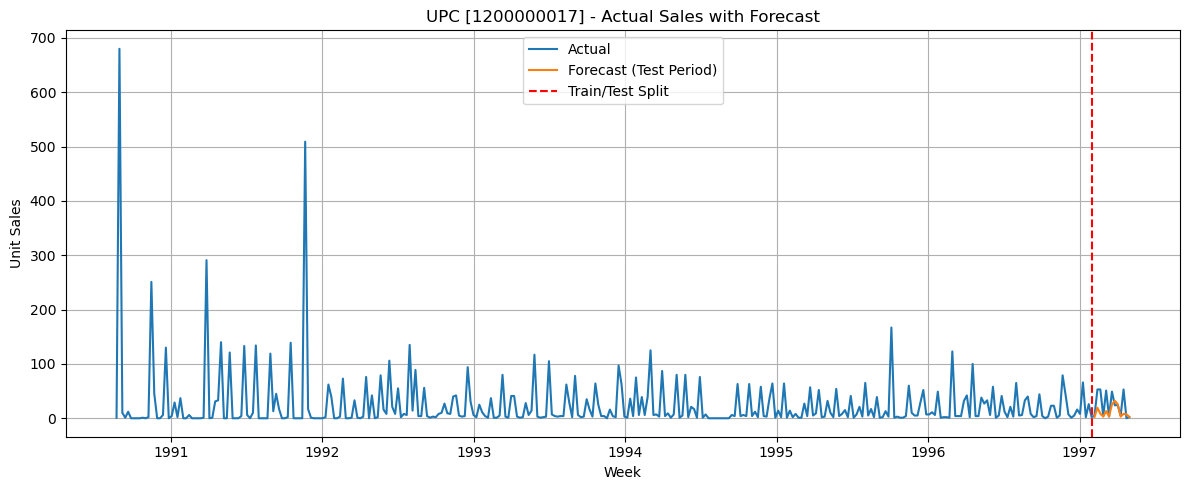

In [73]:
plot_actual_forecast(final_model,df, 'Coca Cola', 1)

### store 2, Coca Cola, Diet, sales forecast

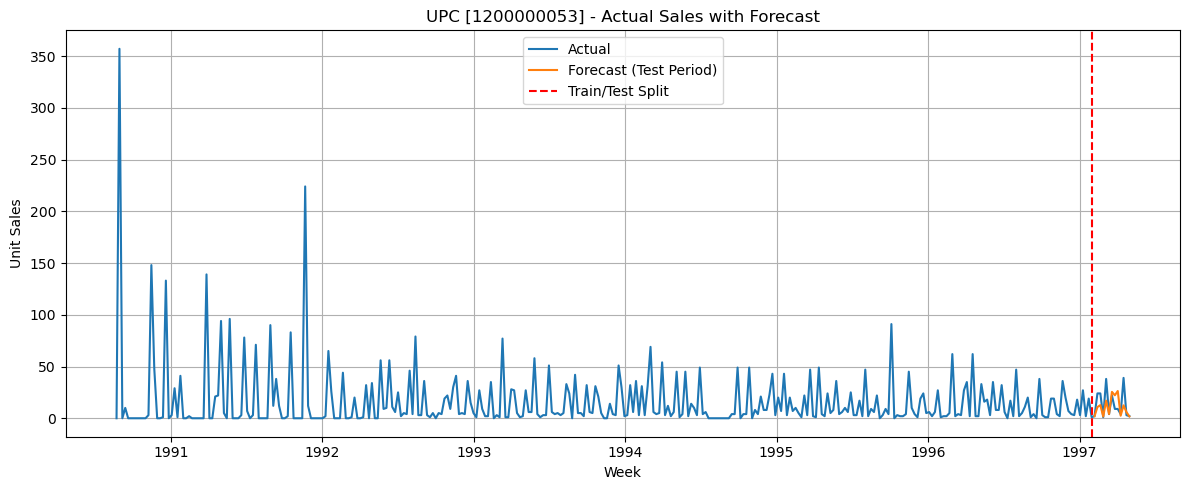

In [75]:
plot_actual_forecast(final_model,df, 'Coca Cola', 0)

### store 2, PEPSI, Regular, sales forecast

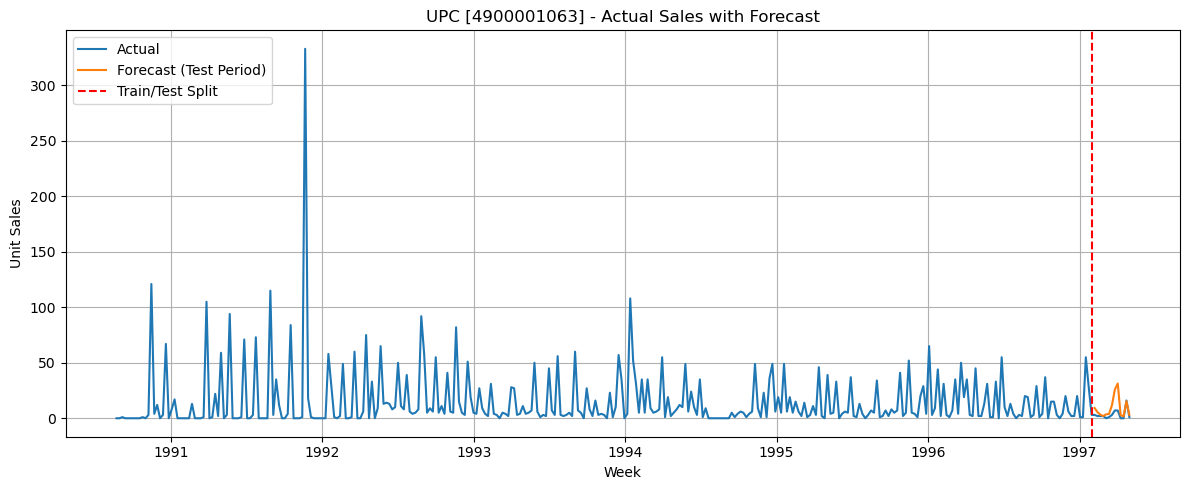

In [77]:
plot_actual_forecast(final_model,df, 'PEPSI', 1)

### store 2, PEPSI, Diet, sales forecast

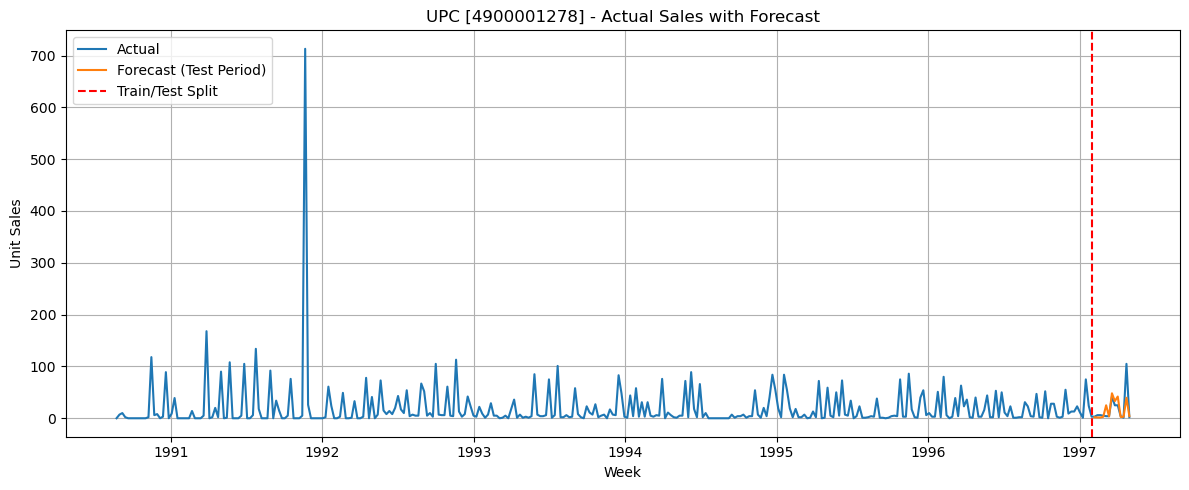

In [79]:
plot_actual_forecast(final_model,df, 'PEPSI', 0)

### feature importance

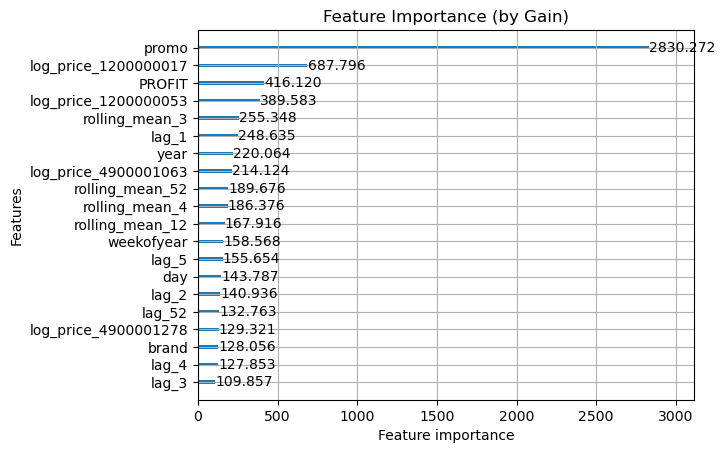

In [81]:
lgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title("Feature Importance (by Gain)")
plt.show()